<h1 style="text-align:center;"><b>Easy Data Augmentation (EDA) for Text Classification with Disaster Tweets</b></h1>

<h2 style="text-align:center;"><b>Course: Introduction to Natural Language Processing</b></h2>

<h3 style="text-align:center;"><b>University of Trento, 2021-22</b></h3>


# 0. Instructions

The notebook is divided into the following sections:
- **1. Setup** 
    - ***1.1 Import libraries***: import the required libraries
    - ***1.2 Set random seed and create useful folders***: set the random seed and create the folders where the results will be saved
- **2. Dataset**
    - ***2.1 Load and prepare Disaster Tweets dataset***: load the dataset and prepare it for the experiments
    - ***2.2 Resampling***: resample the dataset  (optional)
- **3. Data Preprocessing**
    - ***3.1 Cleaning***: clean the tweets
    - ***3.2 EDA: Easy Data Augmentation***: apply EDA to the tweets (optional)
    - ***3.3 Vectorization***: vectorize the tweets
- **4. Models**
    - ***4.1 Multinomial Naive Bayes (MNB)***: train and evaluate the MNB model
    - ***4.2 Logistic Regression (LR)***: train and evaluate the LR model
    - ***4.3 Support Vector Machines (SVM)***: train and evaluate the SVM model
    - ***4.4 Random Forest (RF)***: train and evaluate the RF model

Follow the instructions in the notebook to run the code. 
Remember that if you want to resample the dataset, you have to run the cells in the ***Resampling*** section. Otherwise, you can skip them.
Remember that if you want to use EDAs, you have to run the cells in the ***EDA*** section. Otherwise, you can skip them.

# 1. Setup

## 1.1 Import libraries

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import os

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# sklearn nlp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# keras
import tensorflow as tf

# utils
from utils import save_metrics, print_metrics, plot_confusion_matrix

# preprocessing
from preprocessing import preprocess_data

# data augmentation
from data_augmentation import augment_data

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ivand\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ivand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.2 Set random seed and create useful folders

In [2]:
def set_seed(seed = 16):
    np.random.seed(16)
    tf.random.set_seed(16)

set_seed()

# create a folder called saved_results if it does not exist
if not os.path.exists('saved_results'):
    os.mkdir('saved_results')
    print('saved_results folder created')
else:
    print('saved_results folder already exists')

saved_results folder created


# 2. Dataset

## 2.1 Load and prepare Disaster Tweets dataset
Description: This dataset contains 7613 tweets that were hand classified as disaster or not disaster. The dataset is unbalanced, with only 3271 non-disaster tweets and 4342 disaster tweets. The goal is to predict which tweets are about real disasters and which one’s aren’t.

In [3]:
import pandas as pd

df = pd.read_csv('data/train.csv')
df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
# drop unnecessary columns
df.drop(['id','keyword','location'],axis=1,inplace=True)
df.head(3)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1


In [5]:
# print if there are any missing values
print('There are {} missing values in the dataset'.format(df.isnull().sum().sum()))

# print the number of rows and columns in the dataset
print('There are {} rows and {} columns in the dataset'.format(df.shape[0],df.shape[1]))

# print the names of the columns
print('The names of the columns are: {}'.format(df.columns))

# print the number of tweets per class
print('The number of tweets per class are: ')
print('{}'.format(df.target.value_counts()))


There are 0 missing values in the dataset
There are 7613 rows and 2 columns in the dataset
The names of the columns are: Index(['text', 'target'], dtype='object')
The number of tweets per class are: 
0    4342
1    3271
Name: target, dtype: int64


## 2.2 Resampling the dataset 
Disclaimer: use this code to resample the dataset if you want to use a balanced dataset. Otherwise, skip this cell.

In [6]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.target==0]
df_minority = df[df.target==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df = df_downsampled.copy()

# reset the index
df.reset_index(drop=True,inplace=True)

# print the number of tweets per class
print('The number of tweets per class are: ')
print('{}'.format(df.target.value_counts()))

The number of tweets per class are: 
0    3271
1    3271
Name: target, dtype: int64


# 3. Data Preprocessing

## 3.1 Cleaning

In [7]:
# apply preprocess_data function to the text column
df['clean_text'] = df['text'].apply(lambda x: preprocess_data(x))
df.head(3)

,text,target,clean_text
0,My ear started bleeding again...,0,ear start bleed
1,Dying with debt can be costly for survivors,0,die debt cost survivor
2,@TromboneTristan OOOOOHSHIT OOOHSHIT SCREAMS h...,0,trombonetristan ooooohshit ooohshit scream hel...


In [8]:
# compare the original text with the clean text print the first 3 rows
print(df[['text','clean_text']].head(3))

                                                text  \
0                   My ear started bleeding again...   
1        Dying with debt can be costly for survivors   
2  @TromboneTristan OOOOOHSHIT OOOHSHIT SCREAMS h...   

                                          clean_text  
0                                    ear start bleed  
1                             die debt cost survivor  
2  trombonetristan ooooohshit ooohshit scream hel...  


In [9]:
##  Split the data into train and test sets

df = df[['clean_text','target']]

# rename the column clean_text to text
df.rename(columns={'clean_text':'text'},inplace=True)

# split the data into train and validation set keeping the dataframe structure with text and target

df_train, df_test = train_test_split(df, test_size=0.2, random_state=16)

# print the shape of the train and validation set

print('There are {} rows and {} columns in train'.format(df_train.shape[0],df_train.shape[1]))
print('There are {} rows and {} columns in validation'.format(df_test.shape[0],df_test.shape[1]))

There are 5233 rows and 2 columns in train
There are 1309 rows and 2 columns in validation


## 3.2 EDA: Easy Data Augmentation

In the following section, we will use the textattack library to augment our training data. We will use the EDA (Easy Data Augmentation) technique to augment our training data. The EDA technique is a simple yet effective data augmentation technique that can be used to increase the size of our training data. The technique is based on the following steps:
- Randomly choose n words from the sentence.
- Synonym replacement: Replace each of the n words with one of its synonyms chosen at random.
- Random insertion: Insert n random words at random positions in the sentence.
- Random swap: Randomly swap pairs of words in the sentence n times.

### Methodology

We will apply the EDA technique to our training data. We will use the following parameters:
- n: 4
- alpha: 0.1

From each sentence, we will generate 4 augmented sentences. We will use the alpha parameter to control the number of words that will be replaced, inserted or swapped. The alpha parameter is a float value between 0 and 1. The higher the value of alpha, the more words will be replaced, inserted or swapped.

### Disclaimer
You use the following cells if you want to perform the classification task applying the EDA technique. If you want to use just the original dataset, you can skip the following cells.


In [ ]:
# # print shape of train and test

# print('There are {} rows and {} columns in train'.format(df_train.shape[0],df_train.shape[1]))
# print('There are {} rows and {} columns in validation'.format(df_test.shape[0],df_test.shape[1]))

In [ ]:
# # perform data augmentation on the train set
# df_train = augment_data(df_train, pct_words_to_swap=0.1, transformations_per_example=4)

In [ ]:
# print('There are {} rows and {} columns in train'.format(df_train.shape[0],df_train.shape[1]))
# print('There are {} rows and {} columns in validation'.format(df_test.shape[0],df_test.shape[1]))

## 3.3 Vectorization

In [10]:
# create x_train, y_train, x_val, y_val

x_train, y_train = df_train['text'], df_train['target']
x_test, y_test = df_test['text'], df_test['target']

In [11]:
# instantiate the vectorizer
vect = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
vect.fit(x_train)

# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

# print the number of features
print('There are {} features in x_train_dtm'.format(x_train_dtm.shape[1]))
print('There are {} features in x_test_dtm'.format(x_test_dtm.shape[1]))

There are 10000 features in x_train_dtm
There are 10000 features in x_test_dtm


In [12]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(5233, 10000)
(1309, 10000)


# 4. Models

# 4.1 Multinomial Naive Bayes model

In [13]:
# create a folder called Naive Bayes Model inside the saved_results folder if it does not exist

import os

if not os.path.exists('saved_results/Naive_Bayes_Model'):
    os.makedirs('saved_results/Naive_Bayes_Model')
    print('Folder created')

else:
    print('Folder already exists')


# create AUG Random Forest folder inside the saved_results/Random Forest folder if it does not exist

if not os.path.exists('saved_results/Naive_Bayes_Model/AUG_NB'):
    os.makedirs('saved_results/Naive_Bayes_Model/AUG_NB')
    print('Folder created')

else:
    print('Folder already exists')

Folder created
Folder created


F1-score:  0.7699836867862969
Precision:  0.8237347294938918
Recall:  0.7228177641653905
Acuracy:  0.7845683728036669

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       656
           1       0.82      0.72      0.77       653

    accuracy                           0.78      1309
   macro avg       0.79      0.78      0.78      1309
weighted avg       0.79      0.78      0.78      1309



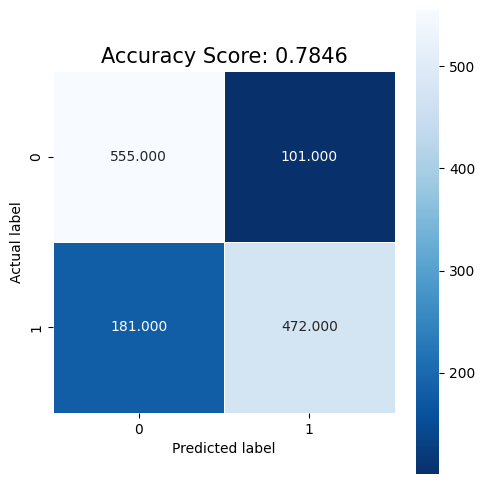

In [14]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_tfidf, y_train)

# Predict the test set
y_pred_class = nb.predict(x_test_tfidf)

print_metrics(y_test, y_pred_class)

plot_confusion_matrix(y_test, y_pred_class, 'saved_results/Naive_Bayes_Model/Naive_Bayes_Confusion_Matrix.png')
# plot_confusion_matrix(y_test, y_pred_class, 'saved_results/Naive_Bayes_Model/AUG_NB/Naive_Bayes_Confusion_Matrix.png')


save_metrics(y_test, y_pred_class, 'saved_results/Naive_Bayes_Model')
# save_metrics(y_test, y_pred_class, 'saved_results/Naive_Bayes_Model/AUG_NB')

# 4.2 Logistic Regression model

In [15]:
# create a folder called LogReg inside the saved_results folder if it does not exist

if not os.path.exists('saved_results/LogReg'):
    os.makedirs('saved_results/LogReg')
    print('Folder created')

else:
    print('Folder already exists')


# create AUG LogReg folder inside the saved_results/LogReg folder if it does not exist

if not os.path.exists('saved_results/LogReg/AUG_LogReg'):
    os.makedirs('saved_results/LogReg/AUG_LogReg')
    print('Folder created')

else:
    print('Folder already exists')

Folder created
Folder created


F1-score:  0.7764518695306285
Precision:  0.8079470198675497
Recall:  0.7473200612557427
Acuracy:  0.7853323147440795

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       656
           1       0.81      0.75      0.78       653

    accuracy                           0.79      1309
   macro avg       0.79      0.79      0.78      1309
weighted avg       0.79      0.79      0.79      1309



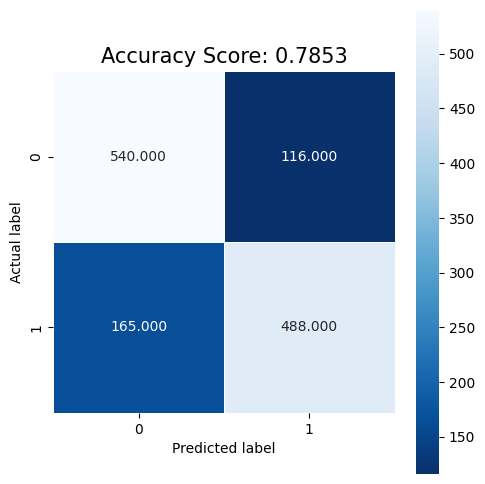

In [16]:
# logistic regression

logreg = LogisticRegression()
logreg.fit(x_train_tfidf, y_train)

# Predict the test set
y_pred_class = logreg.predict(x_test_tfidf)

print_metrics(y_test, y_pred_class)

plot_confusion_matrix(y_test, y_pred_class, 'saved_results/LogReg/LogReg_Confusion_Matrix.png')
# plot_confusion_matrix(y_test, y_pred_class, 'saved_results/LogReg/AUG_LogReg/LogReg_Confusion_Matrix.png')

save_metrics(y_test, y_pred_class, 'saved_results/LogReg')
# save_metrics(y_test, y_pred_class, 'saved_results/LogReg/AUG_LogReg')

# 4.3 Support Vector Machine model

In [17]:
# create a folder called SVM inside the saved_results folder if it does not exist

if not os.path.exists('saved_results/SVM'):
    os.makedirs('saved_results/SVM')
    print('Folder created')

else:
    print('Folder already exists')

# create AUG SVM folder inside the saved_results/SVM folder if it does not exist

if not os.path.exists('saved_results/SVM/AUG_SVM'):
    os.makedirs('saved_results/SVM/AUG_SVM')
    print('Folder created')

else:
    print('Folder already exists')

Folder created
Folder created


F1-score:  0.7673667205169628
Precision:  0.811965811965812
Recall:  0.7274119448698315
Acuracy:  0.7799847211611918

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       656
           1       0.81      0.73      0.77       653

    accuracy                           0.78      1309
   macro avg       0.78      0.78      0.78      1309
weighted avg       0.78      0.78      0.78      1309



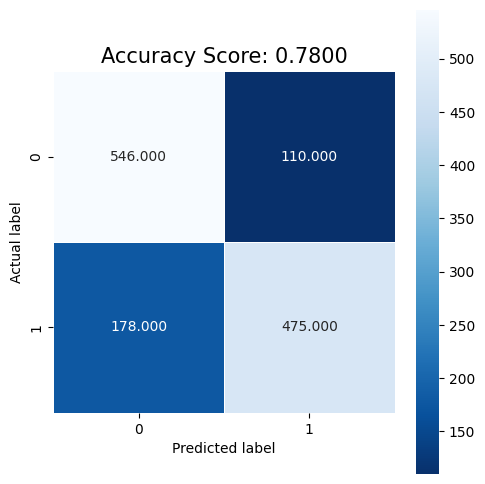

In [18]:
# SVM
svm = SVC(kernel='linear', C=1, probability=True, random_state=42)
svm.fit(x_train_tfidf, y_train)

# Predict the test set
y_pred_class = svm.predict(x_test_tfidf)

print_metrics(y_test, y_pred_class)

plot_confusion_matrix(y_test, y_pred_class, 'saved_results/SVM/SVM_Confusion_Matrix.png')
# plot_confusion_matrix(y_test, y_pred_class, 'saved_results/SVM/AUG_SVM/SVM_Confusion_Matrix.png')

save_metrics(y_test, y_pred_class, 'saved_results/SVM')
# save_metrics(y_test, y_pred_class, 'saved_results/SVM/AUG_SVM')

# 4.4 Random Forest model

In [19]:
# create a folder called Random Forest inside the saved_results folder if it does not exist

if not os.path.exists('saved_results/Random_Forest'):
    os.makedirs('saved_results/Random_Forest')
    print('Folder created')

else:
    print('Folder already exists')

# create AUG Random Forest folder inside the saved_results/Random Forest folder if it does not exist

if not os.path.exists('saved_results/Random_Forest/AUG_Random_Forest'):
    os.makedirs('saved_results/Random_Forest/AUG_Random_Forest')
    print('Folder created')

else:
    print('Folder already exists')

Folder created
Folder created


F1-score:  0.7485760781122864
Precision:  0.7986111111111112
Recall:  0.7044410413476263
Acuracy:  0.7639419404125286

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       656
           1       0.80      0.70      0.75       653

    accuracy                           0.76      1309
   macro avg       0.77      0.76      0.76      1309
weighted avg       0.77      0.76      0.76      1309



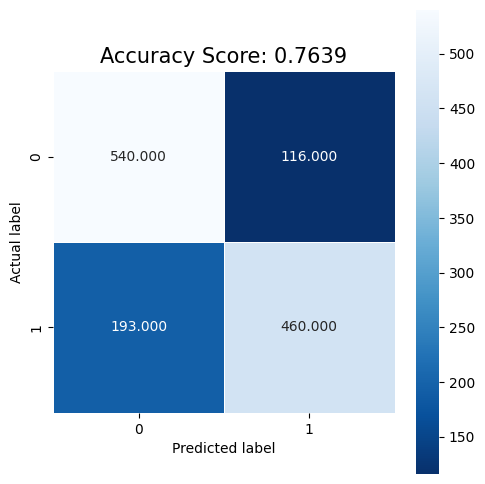

In [20]:
# Random Forest model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train_tfidf, y_train)

# Predict the test set
y_pred_class = rf.predict(x_test_tfidf)

print_metrics(y_test, y_pred_class)

plot_confusion_matrix(y_test, y_pred_class, 'saved_results/Random_Forest/RF_Confusion_Matrix.png')
# plot_confusion_matrix(y_test, y_pred_class, 'saved_results/Random_Forest/AUG_Random_Forest/RF_Confusion_Matrix.png')

save_metrics(y_test, y_pred_class, 'saved_results/Random_Forest')
# save_metrics(y_test, y_pred_class, 'saved_results/Random_Forest/AUG_Random_Forest')